# EDA: Hate Speech Dataset

This notebook explores the hate speech dataset to get insights into the distribution of the dataset and also other key factors which may come handy in modeling.

In [1]:
# Setup
import os, sys, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Robustly add project root (folder containing 'src') to sys.path
from pathlib import Path
def _find_root(start: Path, max_up=5):
    p = start
    for _ in range(max_up):
        if (p / 'src').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start
ROOT = _find_root(Path.cwd())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_ingestion import ingest_from_supabase

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

## Load data from Supabase

In [2]:
df = ingest_from_supabase()
print(f'Shape: {df.shape}')
display(df.head())

2025-09-15 21:37:23,778 [INFO] data_ingestion - Initializing Supabase client for URL: https://hqtospmfdvddjhsiwtck.supabase.co
2025-09-15 21:37:24,764 [INFO] data_ingestion - Ingesting data from Supabase table: Hate Speech Table
2025-09-15 21:37:35,804 [INFO] data_ingestion - Fetched 24783 rows from Hate Speech Table


Shape: (24783, 7)


,Id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


## Missing values
Top columns by number of missing values.

In [6]:
df.isna().sum().sort_values(ascending=False)

Id                    0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

## Comparison: hate_speech vs offensive_language vs neither
This cell computes and visualizes the number of records in each category.

It supports two schemas: (1) a single label column (e.g., class, label) where 0/1/2 map to the three categories; (2) three vote/count columns named hate_speech, offensive_language, and neither, in which case the row's category is argmax of those columns.

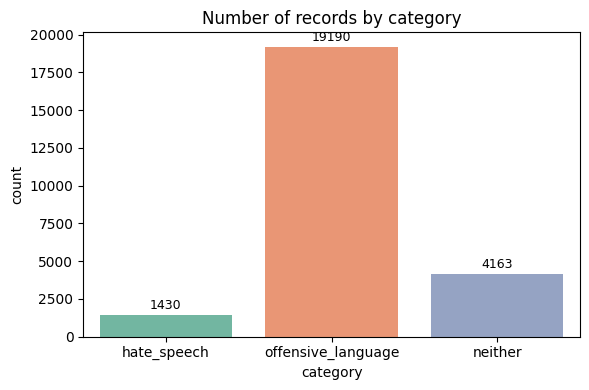

class,hate_speech,offensive_language,neither
count,1430,19190,4163


In [8]:
label_map = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
categories = ['hate_speech', 'offensive_language', 'neither']
counts = None

if not df.empty:
    # Option A: use label/ class column if present
    label_col = next((c for c in ['class','label','target'] if c in df.columns), None)
    if label_col is not None:
        labels = df[label_col]
        if pd.api.types.is_numeric_dtype(labels):
            labels_named = labels.map(label_map).fillna(labels.astype(str))
        else:
            # Normalize to lowercase and expected names if possible
            labels_named = labels.astype(str).str.strip().str.lower()
        counts = labels_named.value_counts().reindex(categories).fillna(0).astype(int)
    else:
        # Option B: derive by majority vote across three columns if available
        if all(c in df.columns for c in categories):
            sub = df[categories].copy()
            # ensure numeric
            for c in categories:
                sub[c] = pd.to_numeric(sub[c], errors='coerce').fillna(0)
            winners = sub[categories].idxmax(axis=1)
            counts = winners.value_counts().reindex(categories).fillna(0).astype(int)

if counts is None:
    print('Could not determine category counts — ensure you have a label column or the three vote columns present.')
else:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values, palette='Set2', ax=ax)
    ax.set_title('Number of records by category')
    ax.set_xlabel('category')
    ax.set_ylabel('count')
    # Annotate bars
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values)*0.01, str(int(v)), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
    display(counts.to_frame('count').T)

# Conclusion
There is clear imbalance in the dataset as can be seen from above as 'offensive_language' comments are much more than 'hate_speech' and 'neither'. This may lead to model bias as the model may learn to classify comments as offensive_language based on the frequency of these words in the dataset.
